# X-Ray Binary Classification

This project is used for generating x-ray binary classifications. 
The dataset is coming from X-Ray Chest Images by Tolga
More detail about dataset: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

The objective about this project is building based model from CNN about image classifications that classifying an image has pneumonia or not.

Talking about pneumonia, you can read more detail about this on this article:

https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204 


FYI:

After train this dataset, the model has an overfitting problem.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os
import zipfile
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import models, layers

# Importing Dataset

Download and unzip the datasets

In [4]:
# Alternatif Download from Github -> WIP
# data = requests.get("")

Extract data into data path

In [5]:
extracted_data_path = 'data/'
zip_path = 'data/archive.zip'

with zipfile.ZipFile(zip_path, 'r') as zipfile:
    zipfile.extractall(extracted_data_path)

print(f"Data was extracted into {extracted_data_path} path") 

Data was extracted into data/ path


Finding the directory informations

In [6]:
dataset_path = 'data/chest_xray'

for dirpath, _, filenames in os.walk(dataset_path):
    folder_name = os.path.basename(dirpath)
    file_count = len([f for f in filenames if not f.startswith(".")]) 
    print(f"Folder: {folder_name}, Banyaknya berkas: {file_count}")

Folder: chest_xray, Banyaknya berkas: 0
Folder: test, Banyaknya berkas: 0
Folder: PNEUMONIA, Banyaknya berkas: 390
Folder: NORMAL, Banyaknya berkas: 234
Folder: train, Banyaknya berkas: 0
Folder: PNEUMONIA, Banyaknya berkas: 3883
Folder: NORMAL, Banyaknya berkas: 3704


## Problem - Imbalenced datasets

In the directory informations, we found that data training with NORMAL labels has smaller than pneumonia. 
This means, the training has imbalanced datasets. 

This problems need to be solved because we are facing the health issues. 
The models need to classify the minority class, which means the models need to good for classifying the NORMAL cases.

**The impact is big if it's wrong**

We are going to implement simple data augmentations with focusing on data rotations around 10 degrees.

### Minority IDG

In [7]:
# Seperate the data based on labels -> only choose Normal (this is the minority)
minority_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

In [8]:
normal_dir = './data/chest_xray/train/NORMAL'
aug_dir = './data/chest_xray/train/NORMAL_augmented'
os.makedirs(aug_dir,exist_ok=True)

In [9]:
images = os.listdir(normal_dir)
target_total = len(images) * 2 #Stopper bcs the objective is multiply the dataset.
generated = 0

for img_name in images:
    img_path = os.path.join(normal_dir, img_name)
    img = load_img(img_path, target_size=[150,150])
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape) # dibutuhkan karena kebutuhan .flow nanti formatnya (1,150,150,3)
    
    for batch in minority_aug.flow(img_array, batch_size=1, save_to_dir=aug_dir, save_prefix='aug', save_format='jpeg'):
        generated += 1
        if generated >= target_total:
            break
    if generated >= target_total:
        break

### Gabungkan dataset yang sudah augmented dengan direktori asli.

In [10]:
for fname in os.listdir(aug_dir):
    shutil.move(os.path.join(aug_dir, fname), os.path.join(normal_dir, fname))

print(f"Sebanyak {len(os.listdir(normal_dir))} data ditemukan pada berkas {normal_dir}")

Sebanyak 7754 data ditemukan pada berkas ./data/chest_xray/train/NORMAL


In [11]:
shutil.rmtree(aug_dir)

# Training

## Build ImageDataGenerator

In [12]:
# Tanpa augmentasi biar ga over.
train_datagen = ImageDataGenerator(
    rescale= 1/.255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/.255,
)

## Build Generator for training & Validation

In [13]:
train_dir = './data/chest_xray/train'
test_dir = './data/chest_xray/test'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    class_mode='binary',
    target_size=[150,150],
    batch_size=32,
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=[150,150],
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=[150,150],
    batch_size=32,
    class_mode='binary',
    shuffle=False # because important to evaluate.
)

Python(67611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Found 9311 images belonging to 2 classes.
Found 2326 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Membangun Arsitektur

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=[150,150,3]),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/dicoding/Dicoding/github/mlops/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Callbacks functions

class myCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('loss') < 0.9):
            self.model.stop_training = True

In [17]:
CALLBACKS = myCallBacks()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[CALLBACKS]
)

/Users/dicoding/Dicoding/github/mlops/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 60s 204ms/step - accuracy: 0.8910 - loss: 140.3783 - val_accuracy: 0.4377 - val_loss: 28.6565
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.9919 - loss: 0.0450 - val_accuracy: 0.4381 - val_loss: 33.6663


# Evaluations

## Loss and Accuracy

In [18]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc: .4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.3354 - loss: 40.4259
Test accuracy:  0.6378


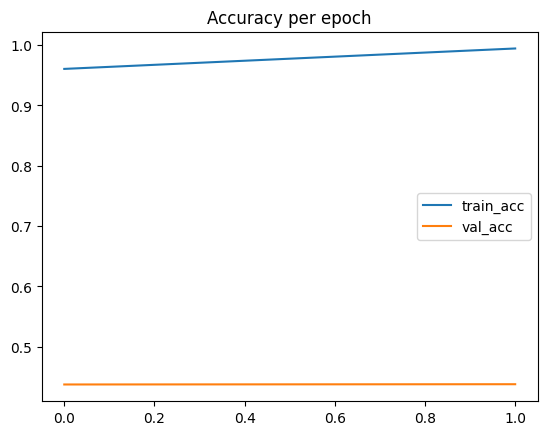

In [19]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

## Predict

Classification Report

In [20]:
y_true = test_gen.classes
y_prob = model.predict(test_gen)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.83      0.04      0.08       234
   PNEUMONIA       0.63      0.99      0.77       390

    accuracy                           0.64       624
   macro avg       0.73      0.52      0.43       624
weighted avg       0.71      0.64      0.51       624



In [43]:
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), output_dict=True)

NORMAL_class = report['NORMAL']
PNEUMONIA_class = report['PNEUMONIA']
prediction_accuracy = report['accuracy']


dict_new = {
        "NORMAL_precision": NORMAL_class['precision'],
        "NORMAL_recall": NORMAL_class['recall'],
        "NORMAL_f1": NORMAL_class['f1-score'] ,
        "PNEUMONIA_precision": PNEUMONIA_class['precision'],
        "PNEUOMONIA_recall":PNEUMONIA_class['recall'],
        "PNEUMONIA_f1": PNEUMONIA_class['f1-score'],
        "predict_acc": prediction_accuracy
    }

dict_new

{'NORMAL_precision': 0.8333333333333334,
 'NORMAL_recall': 0.042735042735042736,
 'NORMAL_f1': 0.08130081300813008,
 'PNEUMONIA_precision': 0.6339869281045751,
 'PNEUOMONIA_recall': 0.9948717948717949,
 'PNEUMONIA_f1': 0.7744510978043913,
 'predict_acc': 0.6378205128205128}

Confusion Matrix

<function matplotlib.pyplot.show(close=None, block=None)>

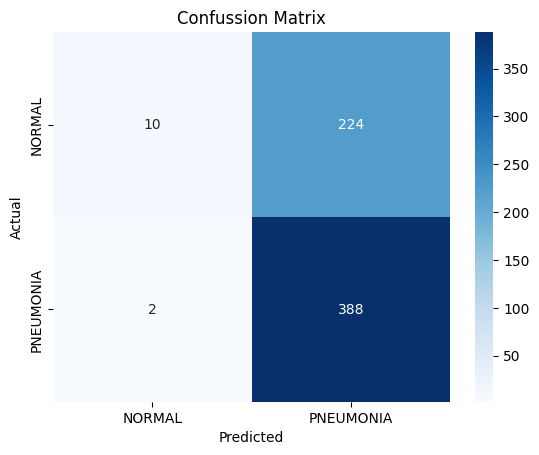

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys(), cmap='Blues')

plt.title("Confussion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show

In [40]:
TN,FP,FN,TP = cm.ravel()

np.int64(2)

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

print(tpr)

[0.         0.91794872 0.92051282 0.92051282 0.92307692 0.92307692
 0.92564103 0.92564103 0.92820513 0.92820513 0.93076923 0.93076923
 0.94102564 0.94102564 0.94615385 0.94615385 0.95128205 0.95128205
 0.95384615 0.95384615 0.95897436 0.95897436 0.96666667 0.96666667
 0.97435897 0.97435897 0.97948718 0.97948718 0.98461538 0.98461538
 0.98717949 0.98717949 0.99230769 0.99230769 0.99487179 0.99487179
 0.9974359  0.9974359  1.         1.        ]


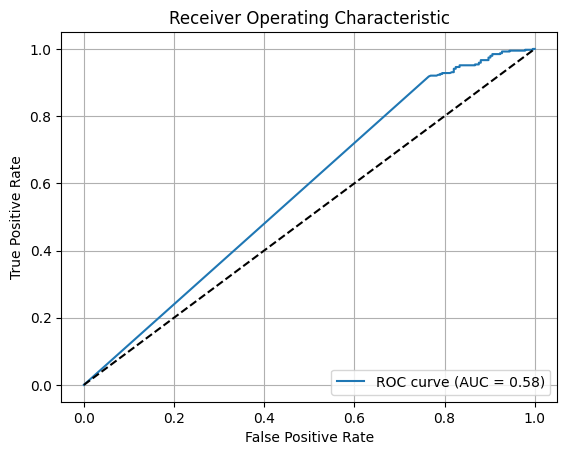

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()

plt.savefig("roc_curve.png")


# Export Model to SavedModel

In [21]:
!mkdir -p ./models/
model.export("./models")

Python(67747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Saved artifact at './models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  6271729328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6271623936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270657280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270659216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270659040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270677408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6270677232: TensorSpec(shape=(), dtype=tf.resource, name=None)
